In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as mg

import seaborn as sns
from matplotlib.patches import Patch
from PIL import Image
from scipy.stats import median_abs_deviation, wilcoxon, ttest_rel

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 150
})
sns.set_style("white")

In [2]:
data = pd.read_csv('/project/deeprna/benchmark/avocado_vs_corgi_results.csv', index_col=0)
data.head()

,tissue,assay,model,pearson,spearman
0,320,h3k4me3,corgi,0.939,0.238
1,320,h3k4me3,avocado,0.949,0.292
2,320,h3k4me3,baseline,0.952,0.313
3,323,h3k4me3,corgi,0.853,0.265
4,323,h3k4me3,avocado,0.871,0.092


In [3]:
data.assay.value_counts()

assay
ctcf        69
h3k27ac     60
rampage     57
dnase       57
h3k4me3     54
h3k4me1     54
h3k27me3    51
h3k36me3    48
h3k9me3     42
wgbs        30
atac        27
cage        21
h3k79me2    18
h3k4me2     15
h3k9ac      12
Name: count, dtype: int64

In [9]:
data = data[data.assay != 'cage']
data = data[data.assay != 'rampage']

In [11]:
data.drop('assay', axis=1).groupby(by='model').mean()

,tissue,pearson,spearman
model,,,
avocado,203.834146,0.623215,0.360546
baseline,203.834146,0.635961,0.407712
corgi,203.834146,0.624620,0.423556


In [20]:
data.groupby(by=['assay', 'model']).mean()

tissue   pearson  spearman
assay    model                                   
atac     avocado   241.888889  0.648667  0.631556
         baseline  241.888889  0.671667  0.680556
         corgi     241.888889  0.653556  0.642889
ctcf     avocado   228.521739  0.676087  0.262130
         baseline  228.521739  0.676174  0.261783
         corgi     228.521739  0.649913  0.284565
dnase    avocado   206.052632  0.849316  0.655421
         baseline  206.052632  0.868737  0.750211
         corgi     206.052632  0.841368  0.727000
h3k27ac  avocado   201.700000  0.611400  0.341050
         baseline  201.700000  0.594950  0.379850
         corgi     201.700000  0.595550  0.386250
h3k27me3 avocado   177.176471  0.435882  0.320235
         baseline  177.176471  0.440941  0.284941
         corgi     177.176471  0.459059  0.331176
h3k36me3 avocado   184.750000  0.562875  0.379625
         baseline  184.750000  0.556562  0.375937
         corgi     184.750000  0.546188  0.372375
h3k4me1  avocado   194.833333  0.432056  0.369556
         baseline  194.833333  0.421333  0.365778
         corgi     194.833333  0.445056  0.396556
h3k4me2  avocado   116.800000  0.774600  0.404200
         baseline  116.800000  0.734800  0.359600
         corgi     116.800000  0.774000  0.387000
h3k4me3  avocado   209.277778  0.850000  0.240611
         baseline  209.277778  0.849556  0.293667
         corgi     209.277778  0.831167  0.310778
h3k79me2 avocado   131.166667  0.725667  0.476500
         baseline  131.166667  0.707333  0.455667
         corgi     131.166667  0.687500  0.454667
h3k9ac   avocado   135.500000  0.697000  0.462500
         baseline  135.500000  0.695000  0.433000
         corgi     135.500000  0.673750  0.417500
h3k9me3  avocado   208.357143  0.412286  0.342714
         baseline  208.357143  0.390000  0.333357
         corgi     208.357143  0.387000  0.343929
wgbs     avocado   223.900000  0.838100  0.812800
         baseline  223.900000  0.901200  0.978100
         corgi     223.900000  0.811600  0.807200

In [14]:
data_pivot = data.pivot(index=["tissue", "assay"], columns="model", values="pearson").reset_index()
data_pivot

model,tissue,assay,avocado,baseline,corgi
0,46,ctcf,0.770,0.760,0.774
1,46,dnase,0.790,0.818,0.783
2,46,h3k27ac,0.409,0.403,0.416
3,46,h3k27me3,0.502,0.426,0.427
4,46,h3k36me3,0.469,0.457,0.455
...,...,...,...,...,...
174,324,ctcf,0.702,0.706,0.665
175,324,h3k27ac,0.750,0.796,0.724
176,324,h3k27me3,-0.139,0.096,0.219
177,324,h3k4me3,0.826,0.832,0.784


In [15]:
def assay_category(assay: str) -> str:
    if assay in ["atac", "dnase"]:
        return "DNase/ATAC"
    elif assay in ["cage", "rampage"]:
        return "CAGE/RAMPAGE"
    elif assay.startswith("h"):  # histone marks
        return "Histone"
    elif assay == "ctcf":
        return "CTCF"
    elif assay == "wgbs":
        return "WGBS"
    else:
        return "Other"

# apply mapping
data_pivot["category"] = data_pivot["assay"].map(assay_category)

In [16]:
def create_figure4(
    data: pd.DataFrame,
    metric: str = "spearman",          # which column to compare (spearman or pearson)
    models: dict = None,               # mapping logical names -> model column names {'corgi':'corgi','avocado':'avocado','baseline':'baseline'}
    figsize=(10,5),
    palette=None,
    output_pdf=None,
    output_png=None
):
    """
    Two side-by-side square scatterplots:
      a) x = avocado, y = corgi
      b) x = baseline, y = corgi

    - Points colored by assay category (derived automatically if not provided).
    - Diagonal x=y drawn.
    - For each plot show two summary numbers only:
        * percent/count where corgi > other (above diagonal)
        * percent/count where other > corgi (below diagonal)
      These are placed in the top-left (above) and bottom-right (below) corners respectively.
    - Legend placed to the right of subplot b.
    - Returns (fig, axs, stats_summary).
    """

    # defaults
    if models is None:
        models = {'corgi':'corgi','avocado':'avocado','baseline':'baseline'}

    # pivot the data into wide format for the chosen metric
    data_pivot = data

    # plotting setup
    fig, axes = plt.subplots(1,2, figsize=figsize, constrained_layout=True)
    axs = axes.ravel()

    comparisons = [
        ('avocado', 'corgi', axs[0], 'Corgi vs Avocado'),
        ('baseline','corgi', axs[1], 'Corgi vs Baseline')
    ]

    # compute global limits across columns that exist
    values_for_limits = []
    for xname, yname, _, _ in comparisons:
        if xname in data_pivot.columns and yname in data_pivot.columns:
            values_for_limits.append(data_pivot[xname].dropna().values)
            values_for_limits.append(data_pivot[yname].dropna().values)
    if len(values_for_limits) == 0:
        raise ValueError("No valid model columns found in pivoted data. Check model names.")
    all_vals = np.concatenate(values_for_limits)
    vmin = np.nanmin(all_vals)
    vmax = np.nanmax(all_vals)
    pad = (vmax - vmin) * 0.05 if vmax > vmin else 0.1
    lim_lo = vmin - pad
    lim_hi = vmax + pad

    stats_summary = {}

    for xname, yname, ax, title in comparisons:
        # skip if required columns missing
        if xname not in data_pivot.columns or yname not in data_pivot.columns:
            ax.set_visible(False)
            continue

        df_plot = data_pivot[[xname, yname, 'assay', 'category']].copy().dropna(subset=[xname, yname])

        # build palette for present categories
        unique_cats = sorted(df_plot['category'].unique())
        sns.scatterplot(
            data=df_plot,
            x=xname,
            y=yname,
            hue='category',
            s=40,
            alpha=0.8,
            edgecolor='k',
            linewidth=0.25,
            ax=ax
        )

        # diagonal
        ax.plot([lim_lo, lim_hi], [lim_lo, lim_hi], color='black', linewidth=1.0, linestyle='--', zorder=2)

        # square axes
        ax.set_xlim(lim_lo, lim_hi)
        ax.set_ylim(lim_lo, lim_hi)
        ax.set_aspect('equal', adjustable='box')

        ax.set_xlabel(f"{xname} ({metric})", fontsize=9)
        ax.set_ylabel(f"{yname} ({metric})", fontsize=9)
        ax.set_title(title, fontsize=11, fontweight='semibold', loc='center')

        # compute above / below diagonal stats (ignore equals)
        mask = (~np.isnan(df_plot[xname])) & (~np.isnan(df_plot[yname]))
        xs = df_plot.loc[mask, xname].values
        ys = df_plot.loc[mask, yname].values
        n = len(xs)
        if n == 0:
            stats_summary[f"{yname}_vs_{xname}"] = {'n': 0, 'above': (0, 0.0), 'below': (0, 0.0)}
            continue
        above = int(np.sum(ys > xs))   # corgi > other
        below = int(np.sum(xs > ys))   # other > corgi
        pct_above = 100.0 * above / n
        pct_below = 100.0 * below / n
        stats_summary[f"{yname}_vs_{xname}"] = {'n': n, 'above': (above, pct_above), 'below': (below, pct_below)}

        x_mean = df_plot[xname].mean()
        y_mean = df_plot[yname].mean()
        
        # place two texts: above (corgi > other) in top-left, below (other > corgi) in bottom-right
        # top-left
        ax.text(
            0.02, 0.95,
            f"{yname} > {xname}\n{pct_above:.1f}%\nμ={y_mean:.3f}",
            transform=ax.transAxes,
            fontsize=9,
            ha='left', va='top',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=3)
        )
        # bottom-right
        ax.text(
            0.98, 0.05,
            f"{xname} > {yname}\n{pct_below:.1f}%\nμ={x_mean:.3f}",
            transform=ax.transAxes,
            fontsize=9,
            ha='right', va='bottom',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=3)
        )

        # minor grid
        ax.grid(alpha=0.12, linestyle='--')

    # move legend to the right of subplot b (axs[1])
    # grab handles/labels from axs[1]
    handles, labels = axs[1].get_legend_handles_labels()
    if handles:
        axs[1].legend(handles=handles, labels=labels, title='Assay category',
                      frameon=False, bbox_to_anchor=(1.02, 0.5), loc='center left')

    # remove legend from axs[0] if present (so it doesn't overlap)
    if axs[0].legend_:
        axs[0].legend_.remove()

    # add panel letters
    axs[0].text(-0.12, 1.03, 'a', transform=axs[0].transAxes, fontsize=13, fontweight='bold', va='top')
    axs[1].text(-0.12, 1.03, 'b', transform=axs[1].transAxes, fontsize=13, fontweight='bold', va='top')

    plt.tight_layout()

    # save if requested
    if output_pdf:
        os.makedirs(os.path.dirname(output_pdf), exist_ok=True)
        fig.savefig(output_pdf, bbox_inches='tight', dpi=300)
    if output_png:
        os.makedirs(os.path.dirname(output_png), exist_ok=True)
        fig.savefig(output_png, bbox_inches='tight', dpi=300)

    return fig, axs, stats_summary


/scratch/local/ipykernel_130010/1304692697.py:147: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


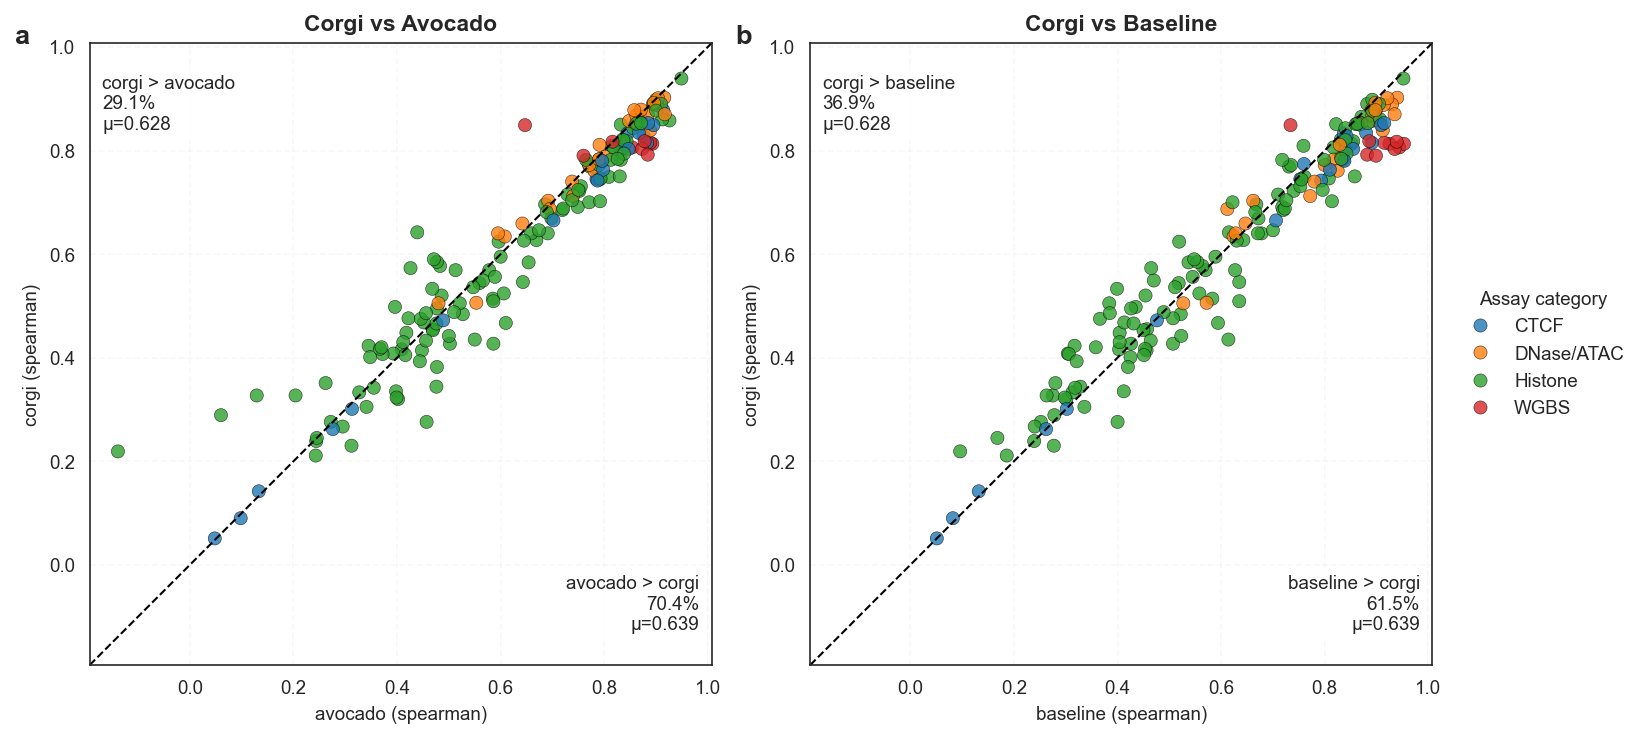

In [17]:
fig, axs, stats = create_figure4(data_pivot, metric='spearman',
                                 models={'corgi':'corgi','avocado':'avocado','baseline':'baseline'},
                                 figsize=(11,5),
                                output_pdf='../figures/figure4.pdf',
                                output_png=None)
plt.show()